In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [3]:
from scipy.stats import spearmanr, pearsonr
import scanpy as sc
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import pickle

In [4]:
#import dynamo as dyn
#dyn.get_all_dependencies_version()

In [4]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'#d8e9f2',zorder=0,linewidth=4)
    plt.scatter(A[msk],B[msk], color='#FF6F3C',\
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

In [5]:
plt.rcParams['font.size'] = '20'
label_font = '20'

# Preparation

!wget -O ./data/rpe1.h5ad https://www.dropbox.com/s/25enev458c8egn7/rpe1.h5ad?dl=1

## Metabolic

In [7]:
rpe1 = sc.read('./data/rpe1.h5ad')
#dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])
rpe1

AnnData object with n_obs × n_vars = 5422 × 11848
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time'
    var: 'Gene_Id'
    layers: 'sl', 'su', 'ul', 'uu'

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


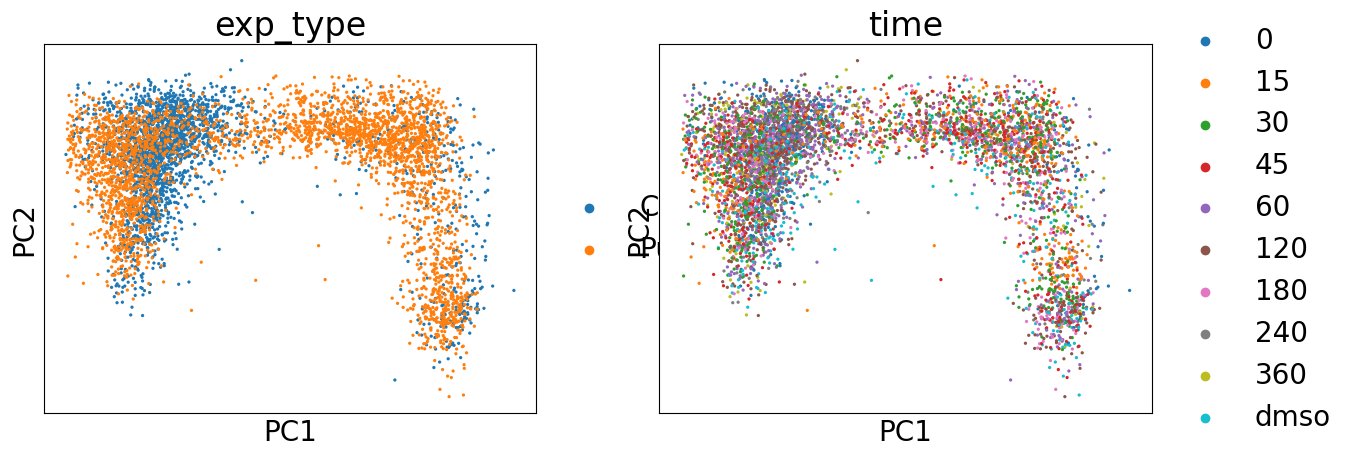

In [8]:
x = np.zeros((rpe1.n_obs,2))
x[:,1] = rpe1.obs['GFP_log10_corrected']
x[:,0] = rpe1.obs['RFP_log10_corrected']

rpe1.obsm['X_pca'] = x
sc.pl.pca(rpe1,color=['exp_type','time'])

KeyboardInterrupt: 

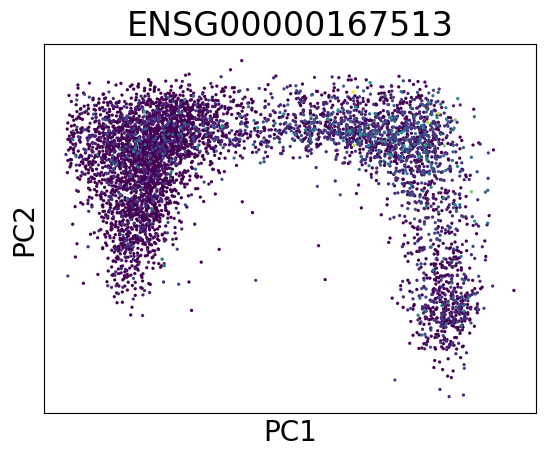

In [9]:
sc.pl.pca(rpe1,color=['ENSG00000167513','ENSG00000112312'])

 ### dynamo

In [ ]:
Chase = rpe1[rpe1.obs.exp_type=='Chase', :]
Chase.obs['time'] = Chase.obs['time'].astype(str)
Chase.obs.loc[Chase.obs['time'] == 'dmso', 'time'] = -1
Chase.obs['time'] = Chase.obs['time'].astype(float)
Chase = Chase[Chase.obs.time != -1, :]
Chase.obs.time = Chase.obs.time/60 # convert minutes to hours

Chase.layers['new'], Chase.layers['total'] = Chase.layers['ul'] + Chase.layers['sl'], Chase.layers['su'] + Chase.layers['sl'] + Chase.layers['uu'] + Chase.layers['ul']
Chase.layers['unspliced'], Chase.layers['spliced'] = Chase.layers['ul'] + Chase.layers['uu'], Chase.layers['su'] + Chase.layers['sl']

In [ ]:
sc.pl.pca(Chase,color=['time'])

In [ ]:
dyn.tl.recipe_deg_data(adata=Chase,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time')

In [ ]:
Pulse = rpe1[rpe1.obs.exp_type=='Pulse', :]
Pulse.obs['time'] = Pulse.obs['time'].astype(str)
Pulse.obs.loc[Pulse.obs['time'] == 'dmso', 'time'] = -1
Pulse.obs['time'] = Pulse.obs['time'].astype(float)
Pulse = Pulse[Pulse.obs.time != -1, :]
Pulse.obs.time = Pulse.obs.time/60 # convert minutes to hours

Pulse.layers['new'], Pulse.layers['total'] = Pulse.layers['ul'] + Pulse.layers['sl'], Pulse.layers['su'] + Pulse.layers['sl'] + Pulse.layers['uu'] + Pulse.layers['ul']
Pulse.layers['unspliced'], Pulse.layers['spliced'] = Pulse.layers['ul'] + Pulse.layers['uu'], Pulse.layers['su'] + Pulse.layers['sl']

In [ ]:
dyn.tl.recipe_kin_data(adata=Pulse,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=False,
                       tkey='time')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Pulse.var['beta'],Pulse.var['beta'],'k')
ax[0].plot(Pulse.var['beta'],Chase.var['beta'],'.')
ax[1].plot(Pulse.var['gamma'],Pulse.var['gamma'],'k')
ax[1].plot(Pulse.var['gamma'],Chase.var['gamma'],'.')

In [ ]:
Chase_dyn = Chase.copy()
Pulse_dyn = Pulse.copy()

### Chase

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_decay(t, beta, rho):
    return rho*np.exp(-beta * t)

# Fit the exponential decay function to the noisy data
initial_guess = (1.0, 1.0)  # Initial guess for the decay rate

T = np.array(list(set(Chase.obs.time)))  # Time points
T

#### Fit marker genes

In [ ]:
marker_genes = np.array(['UNG','PCNA','PLK1','MCM2','CDK1'])
marker_genes_ID = ['ENSG00000076248','ENSG00000132646','ENSG00000166851','ENSG00000073111','ENSG00000170312']
marker_idx = np.arange(Chase.n_vars)[Chase.var_names.isin(marker_genes)]
marker_idx

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    #ax[i].scatter(Chase.obs.time,Chase.layers['ul'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Chase.obs.time == t
        x_[ii] = Chase.layers['ul'].toarray()[idx,j].mean()
    ax[i].scatter(T,x_,color='r',label='mean')
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, x_, p0=initial_guess)
        optimal_beta, rho = optimal_params[:2]
        ax[i].plot(T, exponential_decay(T, optimal_beta, rho), 'b', label='Fitted Curve')
        print("Optimal beta:", optimal_beta)       
    except ValueError:
        pass
    
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()
       

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Chase.obs.time,Chase.layers['ul'].toarray()[:,j]/Chase.layers['unspliced'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Chase.obs.time == t
        x_[ii] = Chase.layers['ul'].toarray()[idx,j].sum()/Chase.layers['unspliced'].toarray()[idx,j].sum()
    ax[i].scatter(T,x_,color='r',label='mean')
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, x_, p0=initial_guess)
        optimal_beta, rho = optimal_params[:2]
        ax[i].plot(T, exponential_decay(T, optimal_beta, rho), 'b', label='Fitted Curve')
        print("Optimal beta:", optimal_beta)       
    except ValueError:
        pass
    
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()
       

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ratios = Chase.layers['ul'].toarray()[:,j]/Chase.layers['unspliced'].toarray()[:,j]
    ax[i].scatter(Chase.obs.time,ratios,color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = (Chase.obs.time == t) & (~np.isnan(ratios))
        x_[ii] = (Chase.layers['ul'].toarray()[idx,j]/Chase.layers['unspliced'].toarray()[idx,j]).mean()
    ax[i].scatter(T,x_,color='r',label='mean')
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, x_, p0=initial_guess)
        optimal_beta, rho = optimal_params[:2]
        ax[i].plot(T, exponential_decay(T, optimal_beta, rho), 'b', label='Fitted Curve')
        print("Optimal beta:", optimal_beta)       
    except ValueError:
        pass
    
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()
       

In [ ]:
## Use only new to fit gamma
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Chase.obs.time,Chase.layers['new'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Chase.obs.time == t
        x_[ii] = Chase.layers['new'].toarray()[idx,j].mean()
    ax[i].scatter(T,x_,color='r')
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, x_, p0=initial_guess)
        optimal_beta, rho = optimal_params[:2]
        ax[i].plot(T, exponential_decay(T, optimal_beta, rho), 'b', label='Fitted Curve')
        print("Optimal beta:", optimal_beta)       
    except ValueError:
        pass
    ax[i].set_title(Chase.var_names[j])
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()

    

In [ ]:
## use ratio to fit gamma

## Use only new to fit gamma
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Chase.obs.time,Chase.layers['new'].toarray()[:,j]/Chase.layers['total'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Chase.obs.time == t
        x_[ii] = Chase.layers['new'].toarray()[idx,j].sum()/Chase.layers['total'].toarray()[idx,j].sum()
    ax[i].scatter(T,x_,color='r')
    ax[i].scatter(T,x_,color='r',label='mean')
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, x_, p0=initial_guess)
        optimal_beta, rho = optimal_params[:2]
        ax[i].plot(T, exponential_decay(T, optimal_beta, rho), 'b', label='Fitted Curve')
        print("Optimal beta:", optimal_beta)       
    except ValueError:
        pass
    
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()    

#### Peusdo-bulk

In [ ]:
X_ = np.zeros((len(T),Chase.n_vars))
for ii,t in enumerate(T):
    idx = (Chase.obs.time == t) 
    print(idx.sum())
    X_[ii] = Chase.layers['ul'].toarray()[idx].mean(axis=0)

optimal_beta = np.zeros(Chase.n_vars)
optimal_rho_beta = np.zeros(Chase.n_vars)
for j in range(Chase.n_vars):
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, X_[:,j], p0=initial_guess)
        optimal_beta[j], optimal_rho_beta[j] = optimal_params
    except (RuntimeError, ValueError):
        optimal_beta[j] = np.nan
        optimal_rho_beta[j] = np.nan

In [ ]:
np.isnan(optimal_beta).sum()/Chase.n_vars

In [ ]:
X_ = np.zeros((len(T),Chase.n_vars))
for ii,t in enumerate(T):
    idx = Chase.obs.time == t
    X_[ii] = Chase.layers['new'].toarray()[idx].mean(axis=0)

optimal_gamma = np.zeros(Chase.n_vars)
optimal_rho_gamma = np.zeros(Chase.n_vars)
for j in range(Chase.n_vars):
    try:
        optimal_params, _ = curve_fit(exponential_decay, T, X_[:,j], p0=initial_guess)
        optimal_gamma[j], optimal_rho_gamma[j] = optimal_params
    except (RuntimeError, ValueError):
        optimal_gamma[j] = np.nan
        optimal_rho_gamma[j] = np.nan

In [ ]:
np.isnan(optimal_gamma).sum()/Chase.n_vars

In [ ]:
reasonable_idx = (optimal_rho_beta>0) & (optimal_rho_gamma>0)
plt.plot(optimal_rho_beta[reasonable_idx],optimal_rho_gamma[reasonable_idx],'.')

In [ ]:
optimal_beta[~reasonable_idx] = np.nan
optimal_gamma[~reasonable_idx] = np.nan

Chase.var['my_beta'] = optimal_beta
Chase.var['my_gamma'] = optimal_gamma

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(Chase.var['my_beta'],Chase.var['my_beta'],'k')
ax[0].plot(Chase.var['my_beta'],Chase.var['beta'],'.')
ax[1].loglog(Chase.var['my_gamma'],Chase.var['my_gamma'],'k')
ax[1].plot(Chase.var['my_gamma'],Chase.var['gamma'],'.')

### Pulse

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_growth(t, beta, rho, tau):
    return rho*(1-np.exp(-beta * (t-tau)))

# Fit the exponential decay function to the noisy data
initial_guess = (1.0, 1.0, 0.2)  # Initial guess for the decay rate

T = np.sort(list(set(Pulse.obs.time)))  # Time points
T

In [ ]:
marker_genes = np.array(['UNG','PCNA','PLK1','MCM2','CDK1'])
marker_genes_ID = ['ENSG00000076248','ENSG00000132646','ENSG00000166851','ENSG00000073111','ENSG00000170312']
marker_idx = np.arange(Pulse.n_vars)[Pulse.var_names.isin(marker_genes)]
marker_idx

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    #ax[i].scatter(Pulse.obs.time,Pulse.layers['ul'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Pulse.obs.time == t
        x_[ii] = Pulse.layers['ul'].toarray()[idx,j].mean()
    ax[i].scatter(T,x_,color='r')
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, x_, p0=initial_guess)
        optimal_beta, rho, tau = optimal_params
        ax[i].plot(T, exponential_growth(T, optimal_beta, rho, tau), 'b', label='Fitted Curve')
        ax[i].legend()
        print("Optimal params:", optimal_beta, rho, tau)      
    except (RuntimeError,ValueError):
        pass
    
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Pulse.obs.time,Pulse.layers['ul'].toarray()[:,j]/Pulse.layers['unspliced'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Pulse.obs.time == t
        x_[ii] = Pulse.layers['ul'].toarray()[idx,j].sum()/Pulse.layers['unspliced'].toarray()[idx,j].sum()
    ax[i].scatter(T,x_,color='r')
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, x_, p0=initial_guess)
        optimal_beta, rho, tau = optimal_params
        ax[i].plot(T, exponential_growth(T, optimal_beta, rho, tau), 'b', label='Fitted Curve')
        ax[i].legend()
        print("Optimal params:", optimal_beta, rho, tau)
    except (RuntimeError,ValueError):
        pass
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ratios = Pulse.layers['ul'].toarray()[:,j]/Pulse.layers['unspliced'].toarray()[:,j]
    ax[i].scatter(Pulse.obs.time,ratios,color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = (Pulse.obs.time == t) & (~np.isnan(ratios))
        x_[ii] = ratios[idx].mean()
    ax[i].scatter(T,x_,color='r')
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, x_, p0=initial_guess)
        optimal_beta, rho, tau = optimal_params
        ax[i].plot(T, exponential_growth(T, optimal_beta, rho, tau), 'b', label='Fitted Curve')
        ax[i].legend()
        print("Optimal params:", optimal_beta, rho, tau)
    except (RuntimeError,ValueError):
        pass
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Pulse.obs.time,Pulse.layers['new'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Pulse.obs.time == t
        x_[ii] = Pulse.layers['new'].toarray()[idx,j].mean()
    ax[i].scatter(T,x_,color='r')
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, x_, p0=initial_guess)
        gamma, rho, tau = optimal_params
        print("Optimal params:", gamma, rho, tau)       
        ax[i].plot(T, exponential_growth(T, gamma, rho, tau), 'b', label='Fitted Curve')
        ax[i].legend()
    except RuntimeError:
        pass
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    

In [ ]:
#chase = alldata[alldata.obs.exp_type == 'Chase', :]
#rd = chase.layers['total'].toarray().mean(0)/chase.layers['total'].toarray().mean()
fig, ax= plt.subplots(1,10,figsize=(60, 4))
for i in range(5):
    j = marker_idx[i]
    ax[i].scatter(Pulse.obs.time,Pulse.layers['new'].toarray()[:,j]/Pulse.layers['total'].toarray()[:,j],color='gray')
    x_ = np.zeros(len(T))
    for ii,t in enumerate(T):
        idx = Pulse.obs.time == t
        x_[ii] = Pulse.layers['new'].toarray()[idx,j].sum()/Pulse.layers['total'].toarray()[idx,j].sum()
    ax[i].scatter(T,x_,color='r',label='data')
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, x_, p0=initial_guess)
        gamma, rho, tau = optimal_params
        print("Optimal params:", gamma, rho, tau)       
        ax[i].plot(T, exponential_growth(T, gamma, rho, tau), 'b', label='Fitted Curve')
    except RuntimeError:
        pass
    ax[i].set_xlabel('Time (t)')
    ax[i].set_ylabel('Fractions (x)')
    ax[i].legend()

In [ ]:
X_ = np.zeros((len(T),Pulse.n_vars))
for ii,t in enumerate(T):
    idx = Pulse.obs.time == t
    X_[ii] = Pulse.layers['ul'].toarray()[idx].mean(0)

optimal_beta = np.zeros(Pulse.n_vars)
optimal_rho_beta = np.zeros(Pulse.n_vars)
optimal_tau_beta = np.zeros(Pulse.n_vars)
for j in range(Pulse.n_vars):
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, X_[:,j], p0=initial_guess)
        optimal_beta[j], optimal_rho_beta[j], optimal_tau_beta[j] = optimal_params
    except (RuntimeError, ValueError):
        optimal_beta[j], optimal_rho_beta[j], optimal_tau_beta[j] = [np.nan]*3

In [ ]:
X_ = np.zeros((len(T),Pulse.n_vars))
for ii,t in enumerate(T):
    idx = Pulse.obs.time == t
    X_[ii] = Pulse.layers['new'].toarray()[idx].mean(0)

optimal_gamma = np.zeros(Pulse.n_vars)
optimal_rho_gamma = np.zeros(Pulse.n_vars)
optimal_tau_gamma = np.zeros(Pulse.n_vars)
for j in range(Pulse.n_vars):
    try:
        optimal_params, _ = curve_fit(exponential_growth, T, X_[:,j], p0=initial_guess)
        optimal_gamma[j], optimal_rho_gamma[j], optimal_tau_gamma[j] = optimal_params
    except (RuntimeError, ValueError):
        optimal_gamma[j] = np.nan
        optimal_rho_gamma[j] = np.nan
        optimal_tau_gamma[j] = np.nan

In [ ]:
reasonable_idx = (np.abs(optimal_tau_beta-optimal_tau_gamma)<0.01) & (optimal_tau_beta>0) & (optimal_tau_gamma>0) & (optimal_tau_beta<0.25) & (optimal_tau_gamma<0.25) & (optimal_rho_beta>0) & (optimal_rho_gamma>0) 
plt.plot(optimal_tau_beta[reasonable_idx],optimal_tau_gamma[reasonable_idx],'.')
plt.figure()
plt.plot(optimal_rho_beta[reasonable_idx],optimal_rho_gamma[reasonable_idx],'.')

In [ ]:
optimal_beta[~reasonable_idx] = np.nan
optimal_gamma[~reasonable_idx] = np.nan
Pulse.var['my_beta'] = optimal_beta
Pulse.var['my_gamma'] = optimal_gamma

### Compare

In [ ]:
np.log(2)/0.01,np.log(2)/0.5

In [ ]:
np.log(2)/10**0.5,np.log(2)/10**1.5

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(Pulse.var['my_beta'],Pulse.var['my_beta'],'k')
ax[0].scatter(Pulse.var['my_beta'],Chase.var['my_beta'],color='b',s=0.1)
ax[0].scatter(Pulse.var['my_beta'],Pulse.var['beta'],color='r',s=0.1)
#ax[0].scatter(Pulse.var['my_beta'],Chase.var['beta'],color='g',s=0.1)

ax[1].loglog(Chase.var['my_gamma'],Chase.var['my_gamma'],'k')
ax[1].scatter(Chase.var['my_gamma'],Pulse.var['my_gamma'],color='b',s=0.1)
ax[1].scatter(Chase.var['my_gamma'],Pulse.var['gamma'],color='r',s=0.1)
#ax[1].scatter(Chase.var['my_gamma'],Chase.var['gamma'],color='g',s=0.1)

In [ ]:
Pulse.var = Pulse.var[['Gene_Id','beta','gamma']]
Pulse.var['beta'] = Pulse.var['beta'].astype(str)
Pulse.var['gamma'] = Pulse.var['gamma'].astype(str)
Pulse.var

In [ ]:
Pulse.write('./data/rpe1_Pulse.h5ad')

## EDA

In [6]:
adata = sc.read('./data/rpe1_Pulse.h5ad')
adata.var

,Gene_Id,beta,gamma
TSPAN6,ENSG00000000003,None,None
DPM1,ENSG00000000419,None,None
SCYL3,ENSG00000000457,None,None
FIRRM,ENSG00000000460,None,None
CFH,ENSG00000000971,None,None
...,...,...,...
CTXND2,ENSG00000283324,None,None
CSNKA2IP,ENSG00000283434,None,None
MIR1244-2,ENSG00000283498,None,None
LOC729732,ENSG00000283674,None,None


In [7]:
adata.var.replace('None', np.nan, inplace=True)

In [8]:
Dynamo_gamma = adata.var['gamma'].astype(float)

In [9]:
# Hela cells
file_path = 'data/Dyrec-seq_ST.xlsx'
df = pd.read_excel(file_path,sheet_name='Table S4',header=2)
#df.head()

# Extract gene name and decay rate columns
Dyrec_data = df.iloc[:,[1,3]].copy()
Dyrec_data.columns = ['Name', 'Decay Rate']

# Print the extracted data
Dyrec_data.head()

Dyrec_gamma = []
data_genes = np.array([gene.upper() for gene in Dyrec_data['Name'].astype(str).tolist()])
data_rates = np.array(Dyrec_data['Decay Rate'].tolist())

gene_name = adata.var_names.tolist()
nan = 0 
for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Dyrec_gamma.append(data_rates[idx])
    else:
        Dyrec_gamma.append(np.nan)
        nan += 1
        
Dyrec_gamma = np.array(Dyrec_gamma)
nan 

7604

In [10]:
# TimeLaspe-seq human K562
file_path = 'data/Schofield_ST2.xlsx'
Schofield = pd.read_excel(file_path,sheet_name='Table S2_K562')

# Calculate decay rate
Schofield['Decay Rate'] = np.log(2) / Schofield['mean_half_life']
Schofield = Schofield[~Schofield['Decay Rate'].isna()]

Schofield.head()

gene_name = adata.var_names.tolist()
Schofield_gamma = []
data_genes = np.array(Schofield['transcript'].tolist())
data_rates = np.array(Schofield['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Schofield_gamma.append(data_rates[idx])
    else:
        Schofield_gamma.append(np.nan)
        nan += 1
        
Schofield_gamma = np.array(Schofield_gamma)
nan 

6633

In [11]:
# Battich
file_path = 'data/Battich_RPE1_Gammas.csv'
Battich_data = pd.read_csv(file_path,header=1)
Battich_data

,gene_Id,gene_name,degradation_rate_Battich_2020_RPE1
0,ENSG00000162772,ATF3,0.126451
1,ENSG00000166845,C18orf54,0.111220
2,ENSG00000210100,MT-TI,0.657299
3,ENSG00000213965,NUDT19,0.103158
4,ENSG00000149100,EIF3M,0.059313
...,...,...,...
6081,ENSG00000115993,TRAK2,0.134040
6082,ENSG00000131171,SH3BGRL,0.095601
6083,ENSG00000107518,ATRNL1,0.580815
6084,ENSG00000155366,RHOC,0.028213


In [12]:
Battich_gamma = []
data_genes = np.array([gene.upper() for gene in Battich_data['gene_name'].astype(str).tolist()])
data_rates = np.array(Battich_data['degradation_rate_Battich_2020_RPE1'].astype(float).tolist())

gene_name = adata.var_names.tolist()
nan = 0 
for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Battich_gamma.append(data_rates[idx])
    else:
        Battich_gamma.append(np.nan)
        nan += 1
        
Battich_gamma = np.array(Battich_gamma)
nan 

5708

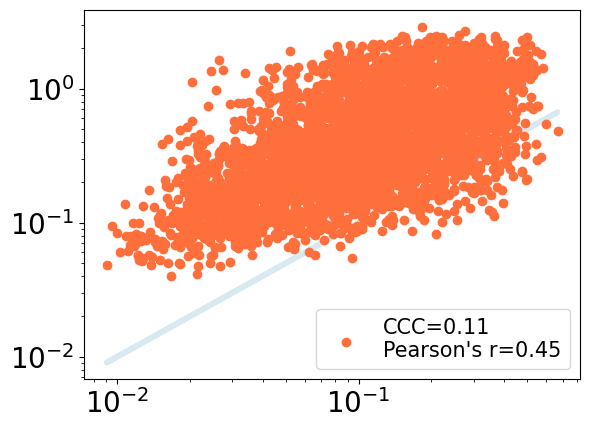

In [13]:
plot_cor(Battich_gamma,Schofield_gamma);

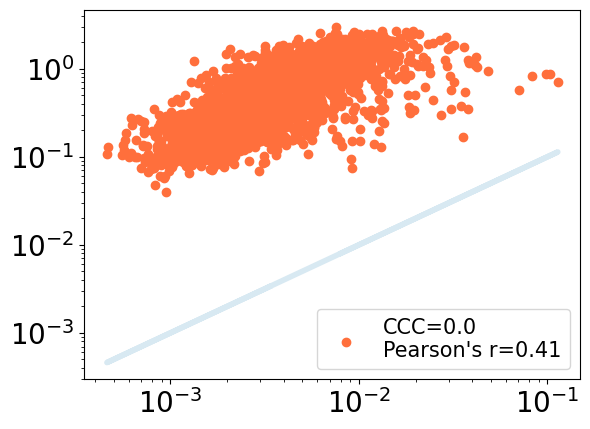

In [14]:
plot_cor(Dyrec_gamma,Schofield_gamma);

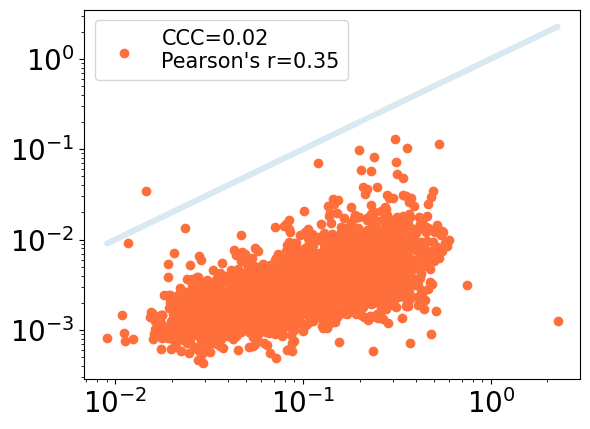

In [15]:
plot_cor(Battich_gamma,Dyrec_gamma);

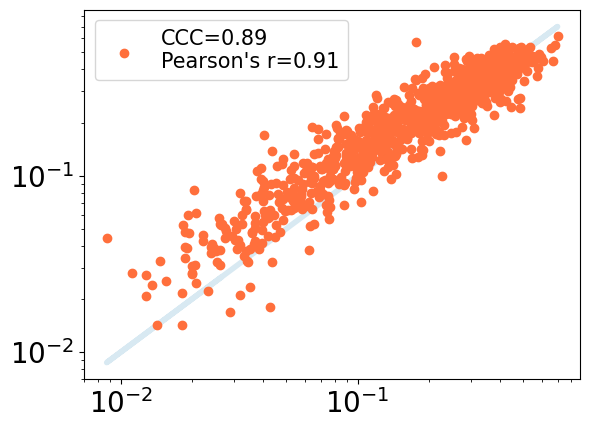

In [16]:
plot_cor(Battich_gamma,Dynamo_gamma);

**Define marker genes and load gene length data**

In [17]:
marker_genes = ['UNG','PCNA','PLK1','MCM2','CDK1','CDK2','CDK3','CDK4','CDK5','CDK6']
#marker_genes = ['ENSG00000076248','ENSG00000132646','ENSG00000166851','ENSG00000073111','ENSG00000170312']
plot_marker_genes = adata.var_names[adata.var_names.isin(marker_genes)]
print(plot_marker_genes)

Index(['MCM2', 'UNG', 'CDK6', 'CDK2', 'PCNA', 'CDK4', 'CDK5', 'PLK1', 'CDK1'], dtype='object')


In [18]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
Lb_gene_length = np.array([int(gene[1]) for gene in gene_length_file])
Lb_gene_name = np.array([gene[0].upper() for gene in gene_length_file])
print(np.sum(adata.var_names.isin(Lb_gene_name)))

11012


**PCA plots and marker gene expresssion**

**Define clusters and cell colors**

In [19]:
xx = adata.obs['RFP_log10_corrected'].astype(float)

In [20]:
clusters = np.around(xx/xx.max()*2,0)

In [21]:
Clusters = [[0],[1],[2]]

In [22]:
color_palette = ["#f7f7f7","#dfe3ee","#8b9dc3","#3b5998"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin(Cluster)
    cell_colors[idx] = cmap_cluster(i)[:3]

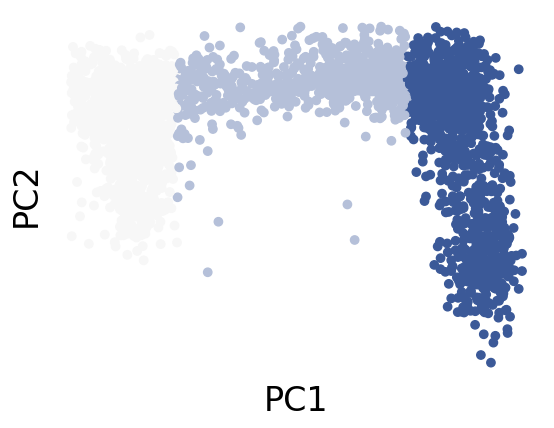

In [23]:
x = np.zeros((adata.n_obs,2))
x[:,1] = adata.obs['GFP_log10_corrected']
x[:,0] = adata.obs['RFP_log10_corrected']

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

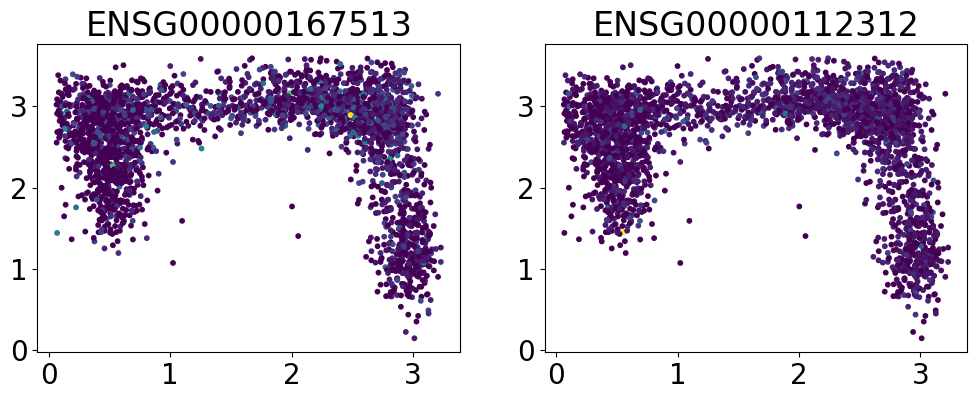

In [24]:
Genes = ['ENSG00000167513','ENSG00000112312']

fig, ax = plt.subplots(1,2,figsize=(12,4))
for i,gene in enumerate(Genes):
    ax[i].set_title(gene)
    ax[i].scatter(x[:,0],x[:,1],c=adata.layers['total'].toarray()[:,adata.var['Gene_Id'].isin([gene])]/adata.layers['total'].toarray().mean(axis=1,keepdims=True)*adata.layers['total'].toarray().mean(),s=10,cmap='viridis');

## Select genes

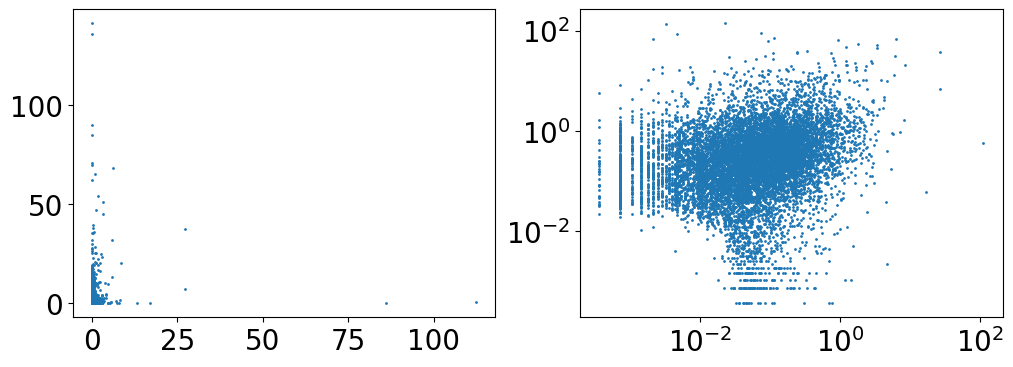

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [26]:
idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total S counts = 0.18038433066450654
s estimated by normalized covariance of total counts = 0.16218970910033564
s estimated by total counts = 0.16879102186270975


s estimated by normalized covariance of Poission genes = 0.16029452125861335


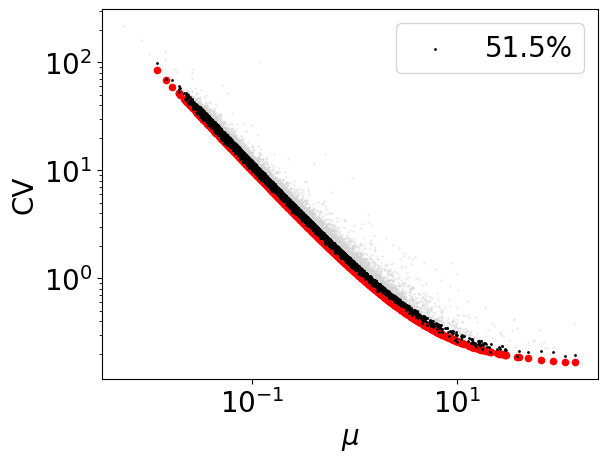

In [27]:
a=1
s=s1

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.2)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

s estimated by normalized covariance of Poission genes = 0.16595041888118417


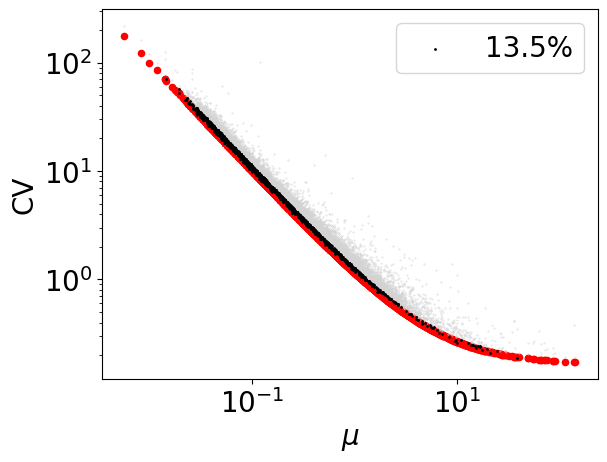

In [28]:
Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar, a/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

0.16888135337061136

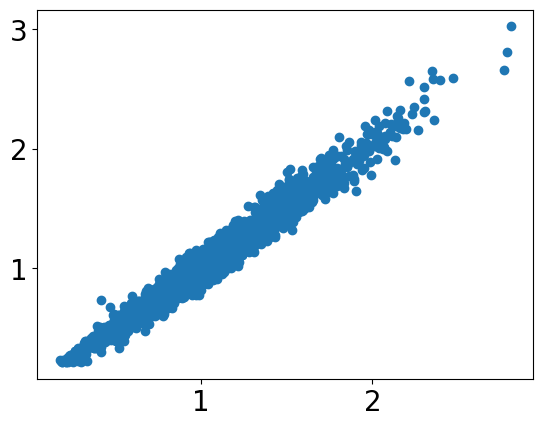

In [29]:
read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

XX = U + S
total_counts = XX.mean(1)/XX.mean()
plt.figure()
plt.scatter(rd,total_counts)

total_counts.var()

In [30]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + s*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_3270607/1641975632.py:7: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s*U_mean**2) > var_threshold) \
/tmp/ipykernel_3270607/1641975632.py:8: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + s*S_mean**2) > var_threshold) \
/tmp/ipykernel_3270607/1641975632.py:9: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_3270607/1641975632.py:9: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)


1025

In [31]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
cell_cycle_genes = np.array([gene.upper() for gene in cell_cycle_genes])
fitted_genes = fitted_genes[fitted_genes.isin(cell_cycle_genes)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(np.sum(fitted_genes.isin(cell_cycle_genes)))

141


141


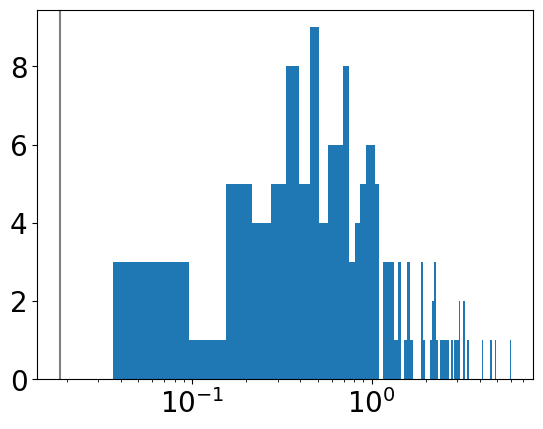

In [32]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

/tmp/ipykernel_3270607/827676432.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + s, c='r', s=20)
/tmp/ipykernel_3270607/827676432.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp/ipykernel_3270607/827676432.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + s, c='r', s=20)
/tmp/ipykernel_3270607/827676432.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(2793, 141, 2)

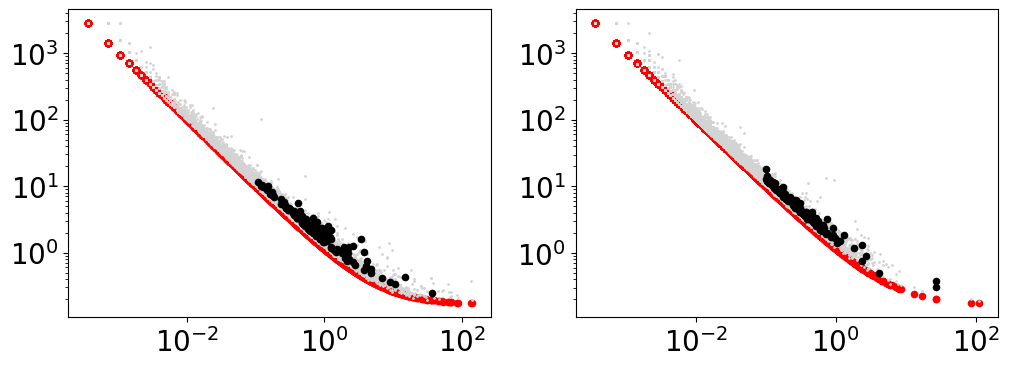

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [34]:
Pulse_genes = fitted_genes.copy()
Pulse_genes

Index(['ANLN', 'RABGAP1', 'BRCA1', 'UBR2', 'PIAS1', 'SPDL1', 'FOXN3', 'MTA3',
       'PPP1R12A', 'CDK17',
       ...
       'PBX1', 'MYBL1', 'KIF18B', 'LIN54', 'BLM', 'UVRAG', 'FOXJ3', 'SMC5',
       'TOP1', 'UHRF1'],
      dtype='object', length=141)

In [35]:
adata.uns['fitted_genes'] = Pulse_genes #[Pulse_genes.isin(Chase_genes)]
fitted_genes = adata.uns['fitted_genes']

In [36]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
if plot_idx.sum() == 0:
    plot_idx = np.arange(10)
else:
    print(fitted_genes[plot_idx])

Index(['MCM2', 'CDK6'], dtype='object')


In [37]:
np.savetxt("data/fitted_cell_cycle_genes.txt",fitted_genes.tolist(),fmt="%s")

## Get X

(2793, 141, 2)

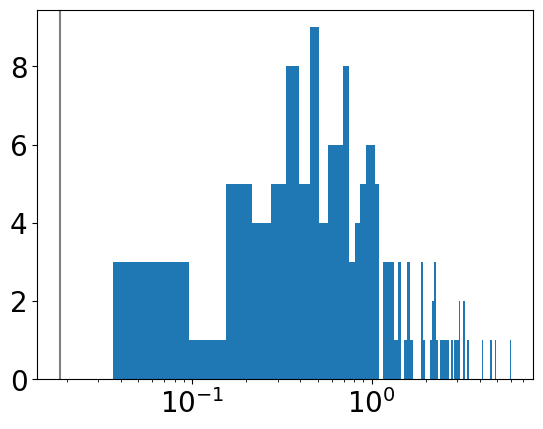

In [38]:
fitted_genes = np.loadtxt("data/fitted_cell_cycle_genes.txt",dtype=str)
fitted_idx = adata.var_names.isin(fitted_genes)

Ub_gene_idx = np.array([ np.where(Lb_gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes],dtype=int)
Ub = 10**(-5)*Lb_gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

0.16888135337061136

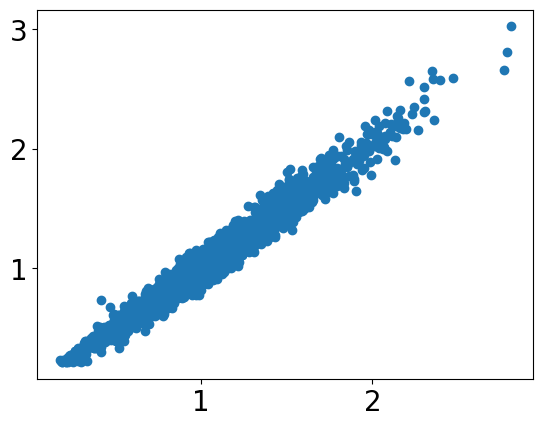

In [39]:
U = adata.layers["unspliced"].toarray()
S = adata.layers["spliced"].toarray()

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,total_counts)
rd = total_counts
rd.var()

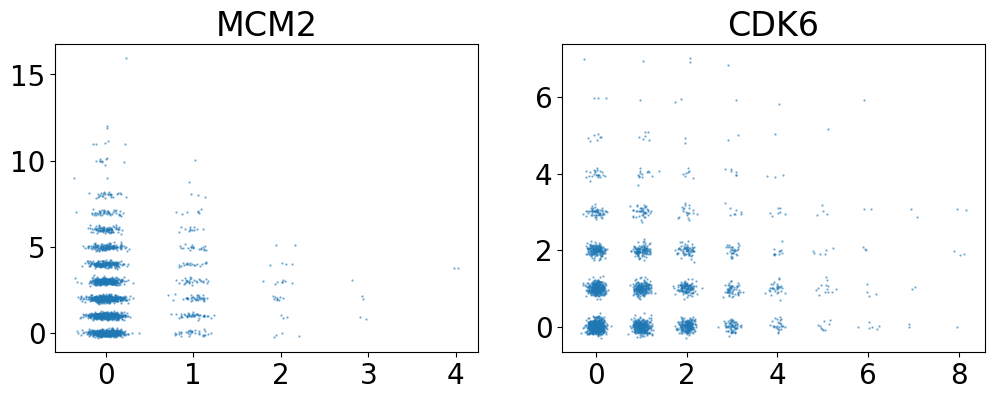

In [40]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
pp = len(plot_idx)

if len(plot_idx) == 0:
    pass
elif len(plot_idx) == 1:
    j = plot_idx
    plt.scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])
else:
    fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
    for i in range(len(plot_idx)):
        j = plot_idx[i]
        ax[i].set_title(fitted_genes[j])
        ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [41]:
xx = adata.obs['RFP_log10_corrected'].astype(float)
clusters = np.around(xx/xx.max()*2,0)

x = np.zeros((adata.n_obs,2))
x[:,1] = adata.obs['GFP_log10_corrected']
x[:,0] = adata.obs['RFP_log10_corrected']

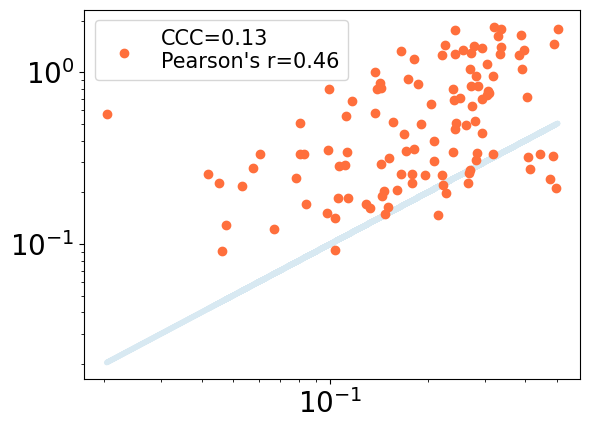

In [42]:
plot_cor(Battich_gamma[fitted_idx],Schofield_gamma[fitted_idx]);

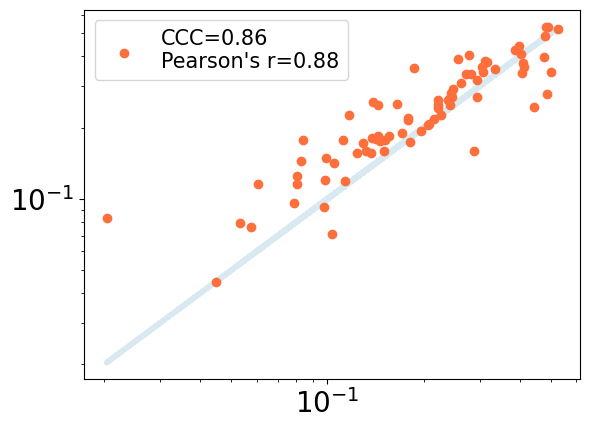

In [43]:
plot_cor(Battich_gamma[fitted_idx],adata.var['gamma'][fitted_idx].astype(float));

## Mixtures fitting

1 -286.1632814766899 -286.2642481791604 -286.56386038496
2 -280.57604278127263 -280.7783342241656 -281.37862109039526
3 -277.81106874714953 -278.114684930465 -279.0156464571247
4 -276.3871371925754 -276.7920781163133 -277.9937143034032
5 -275.3689638114277 -275.8752294755881 -277.37754032310806
6 -274.86531339225814 -275.472903796841 -277.27588930479106


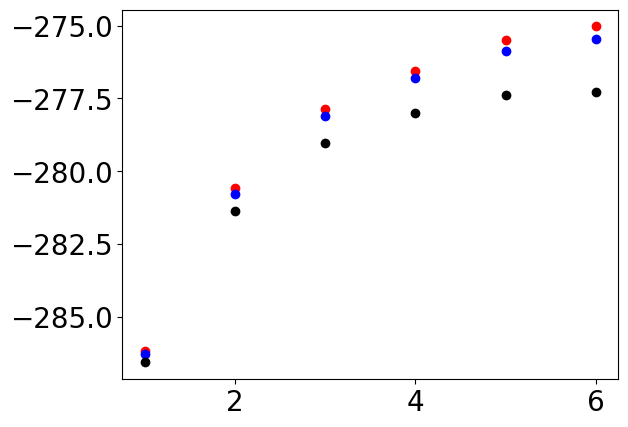

In [44]:
X_mix = X

PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

array([0.30872894, 0.48533637, 0.20593469])

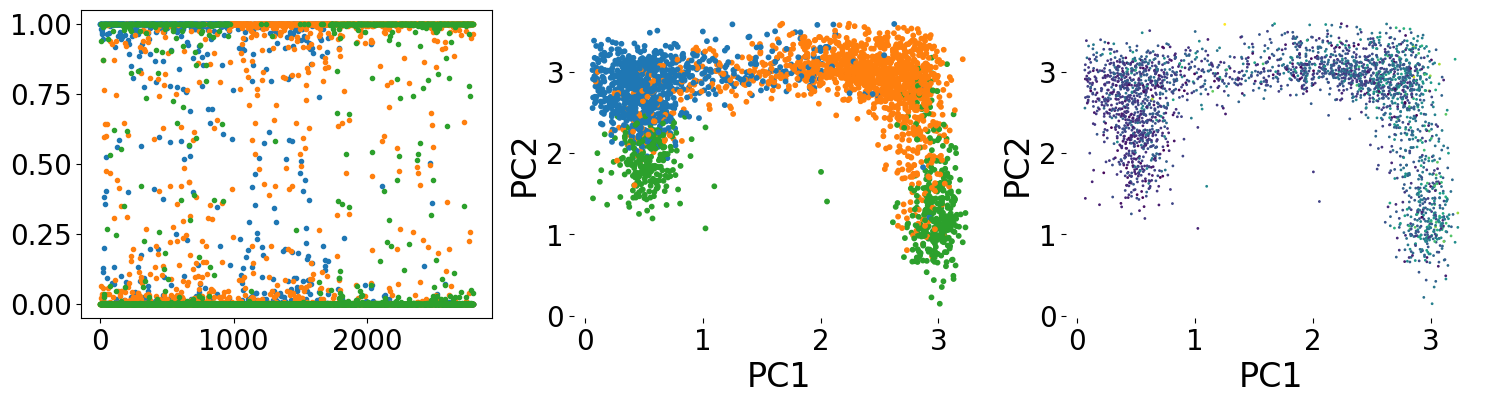

In [46]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=1)],s=10);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

ax[2].scatter(x[:,0],x[:,1],c=rd,s=1);
ax[2].set_xlabel('PC1',fontsize=24)
ax[2].set_ylabel('PC2',fontsize=24)
ax[2].set_frame_on(False)
PM.weights

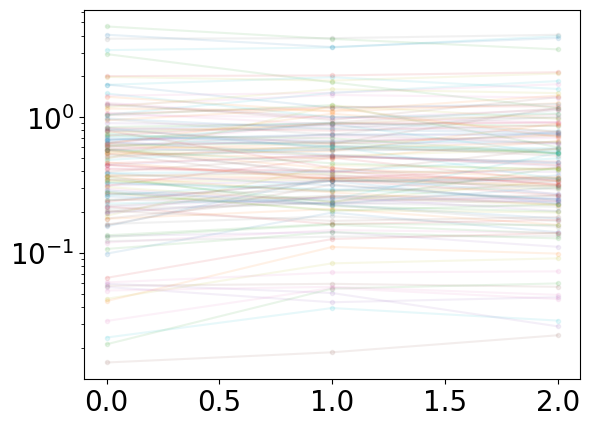

In [47]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

# Trajectory fitting

In [48]:
elbos = {}
traj_params={"r":rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [49]:
clusters = pd.Series(np.argmax(Q,axis=1))
#clusters = np.around(xx/xx.max()*2,0)
Clusters = [0,1,2]

0.30934479054779807
0.48370927318295737
0.20694593626924454


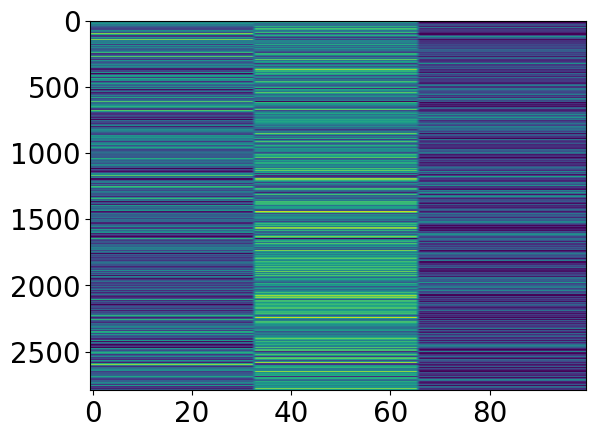

In [50]:
m=100
weight0 = np.ones((adata.n_obs,1,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    print(idx.sum()/adata.n_obs)
    weight0[idx,:,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=(1,2),keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0
plt.imshow(Q0[:,0],aspect='auto')

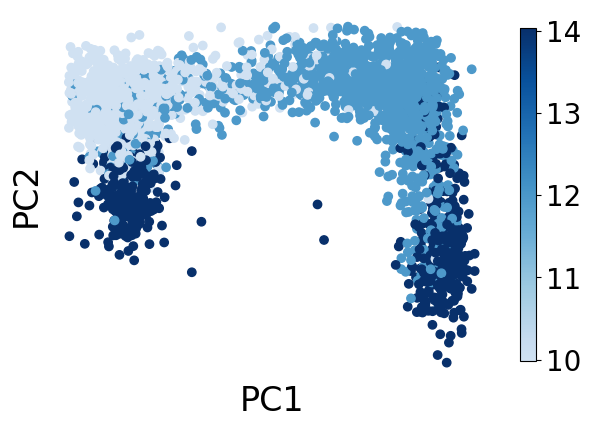

In [51]:
t_hat = Q0.sum(1)@np.linspace(0,24,m)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [71]:
topo = np.array([[0,1,2,0]])
tau = (0,8,16,24)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 100/100 [08:46<00:00,  5.26s/it]

-276.33867232644246


[ 0.          9.21091619 18.89971223 24.        ]


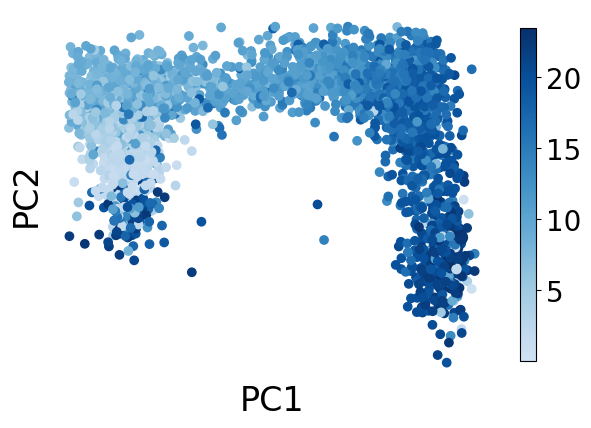

In [72]:
t_hat = traj.Q.sum(1)@traj.t
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
print(traj.tau)

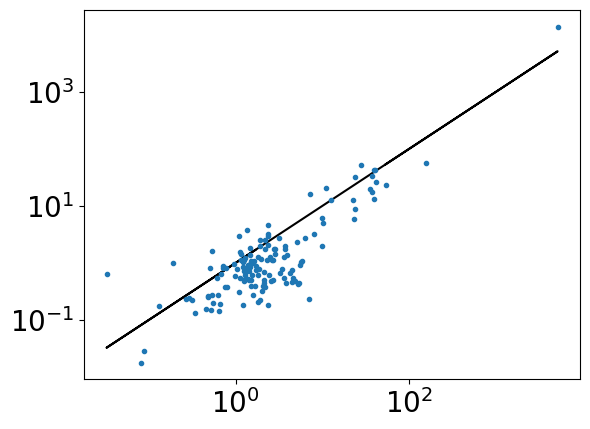

In [73]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

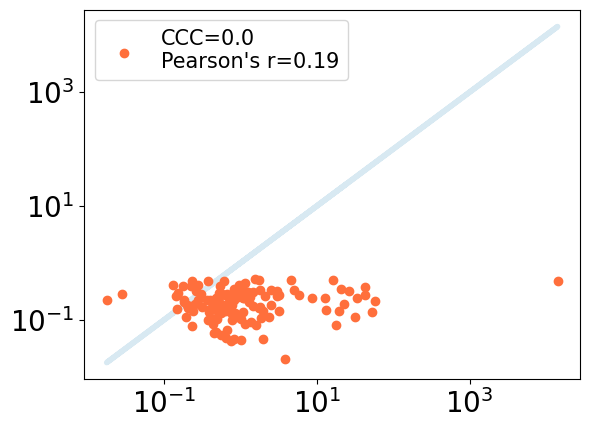

In [74]:
A = traj.theta[:,-1]
B = Battich_gamma[fitted_idx]
plot_cor(A,B)

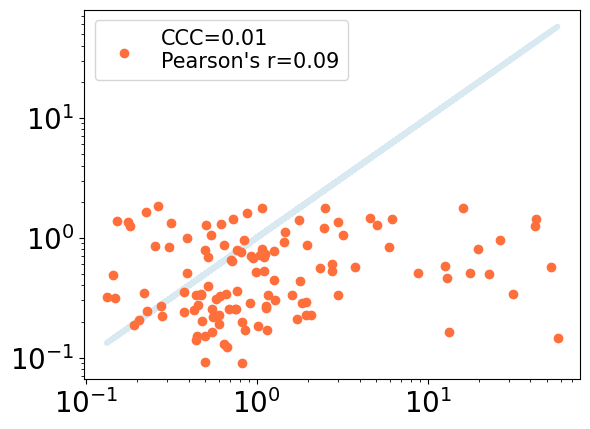

In [75]:
A = traj.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

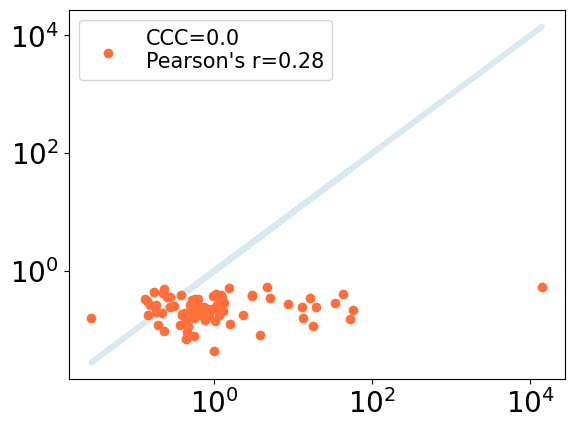

In [76]:
A = traj.theta[:,-1]
B = Dynamo_gamma[fitted_idx]
plot_cor(A,B)

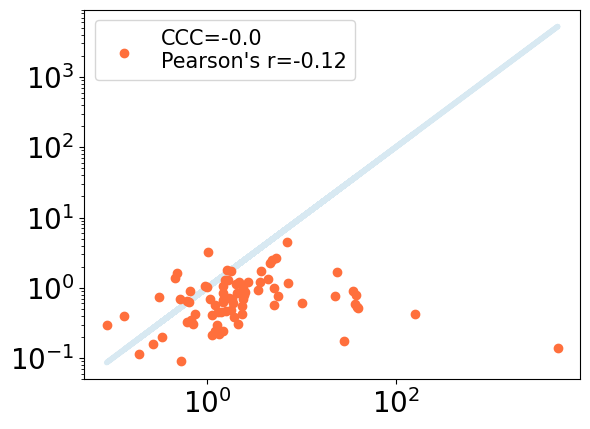

In [77]:
A = traj.theta[:,-2]
B = adata.var['beta'].astype(float)[fitted_idx]
plot_cor(A,B)

In [89]:
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params={"r":rd,"Ub":Ub,"lambda_tau":0.01},Q=traj.Q.copy(),parallel=True,n_threads=10,epoch=100)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 100/100 [13:10<00:00,  7.91s/it]

-302.3943493263834


[ 0.          9.21091619 18.89971223 24.        ]


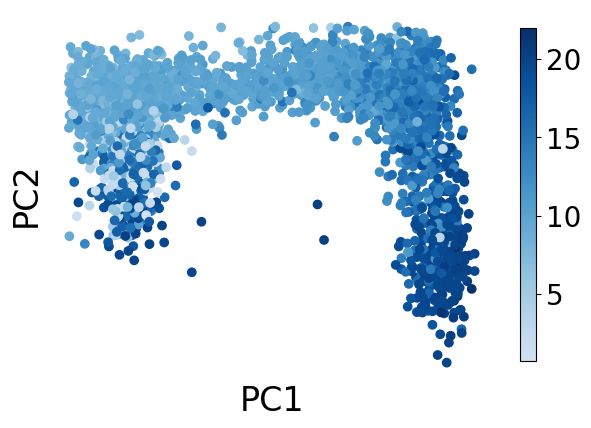

In [90]:
traj = traj_tau
print(traj.tau)
t_hat = np.sum(traj.Q@traj.t,axis=1)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

(array([ 1.,  0.,  4.,  7., 14., 75., 15., 13.,  3.,  9.]),
 array([8.70088741, 8.80289317, 8.90489892, 9.00690468, 9.10891043,
        9.21091619, 9.31292194, 9.4149277 , 9.51693346, 9.61893921,
        9.72094497]),
 <BarContainer object of 10 artists>)

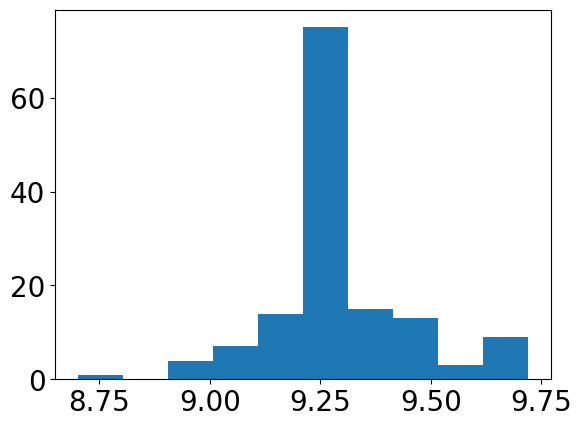

In [91]:
plt.hist(traj.theta[:,3])

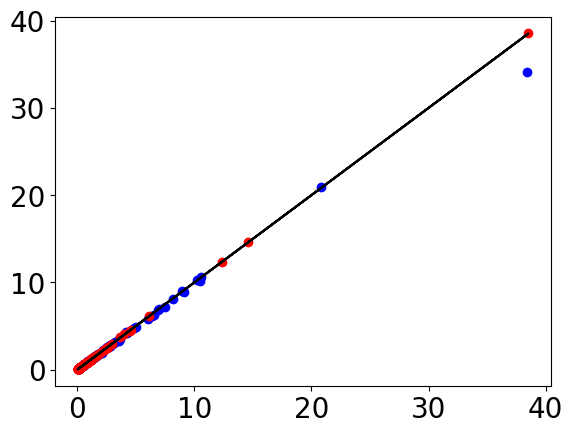

In [93]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
plt.plot(Y[0,0,:,0],Y[0,0,:,0],'k-')
plt.plot(Y[0,0,:,1],Y[0,0,:,1],'k-')
plt.scatter(Y[0,0,:,1],Y[0,-1,:,1],color='b')
plt.scatter(Y[0,0,:,0],Y[0,-1,:,0],color='r')

0.16888135337061136
0.11188895701565574 1.4227012131066683


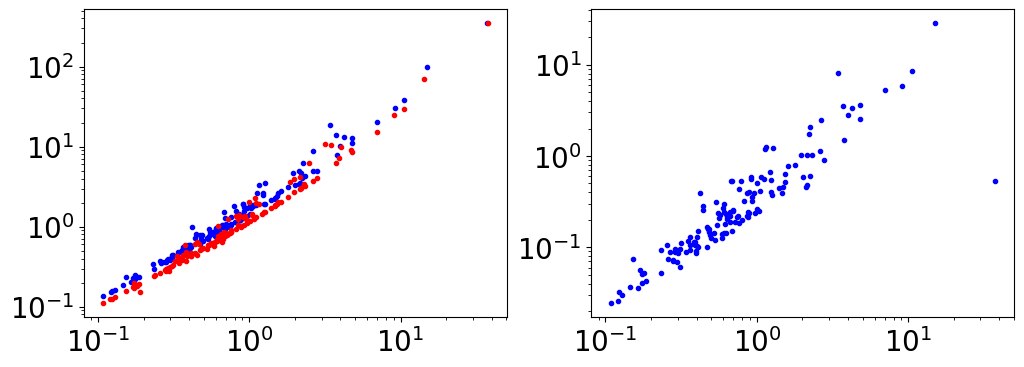

In [94]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(mean,var,'b.');
ax[0].loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.');
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())
ax[1].loglog(mean,unexplained,'b.');

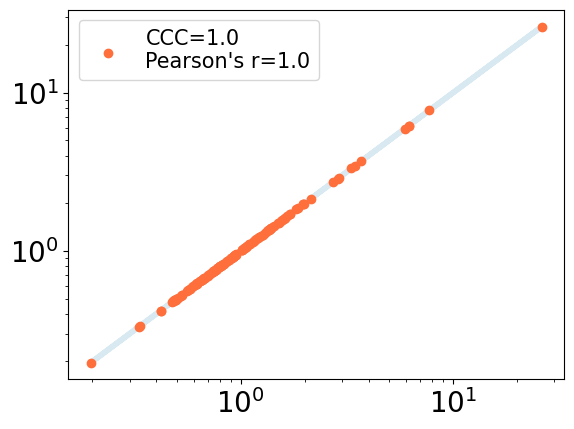

In [95]:
A = traj.theta[:,-1]
B = traj_tau.theta[:,-1]
plot_cor(A,B)

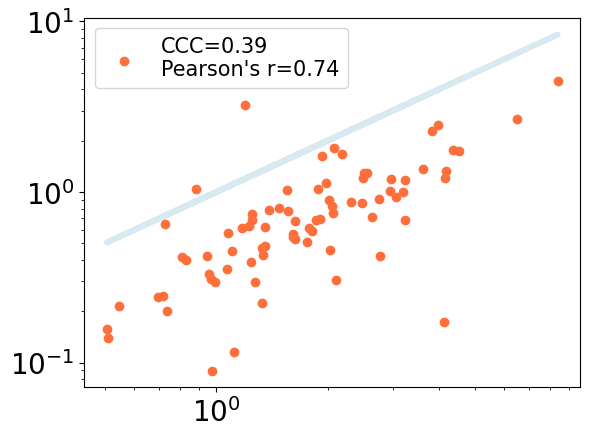

In [96]:
A = traj.theta[:,-2]
B = adata.var['beta'].astype(float)[fitted_idx]
plot_cor(A,B)

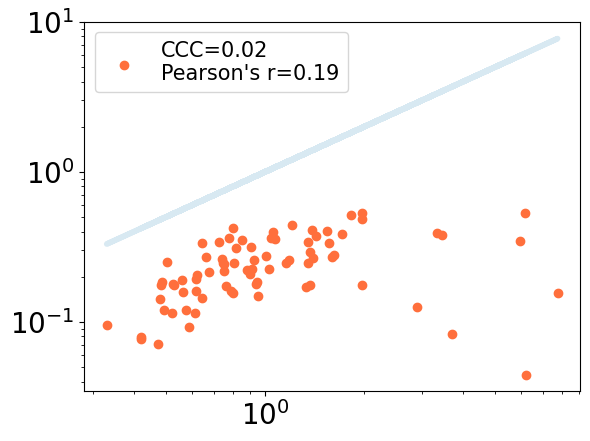

In [97]:
A = traj.theta[:,-1]
B = Dynamo_gamma[fitted_idx]
plot_cor(A,B)

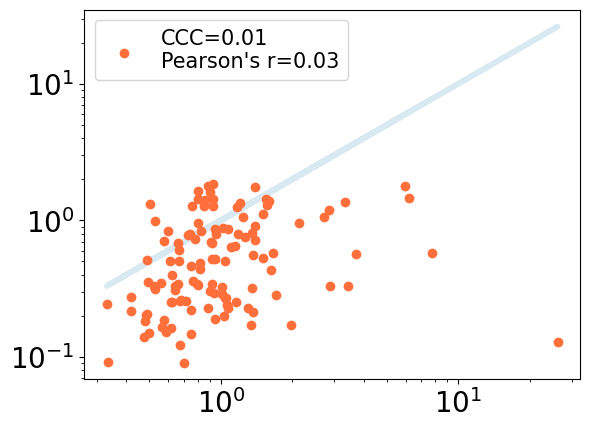

In [98]:
A = traj.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

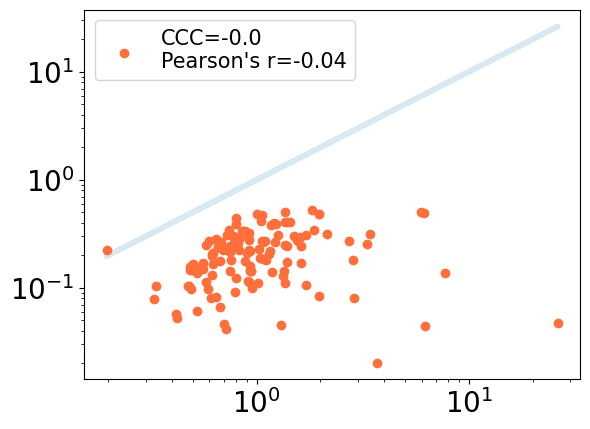

In [99]:
A = traj.theta[:,-1]
B = Battich_gamma[fitted_idx]
plot_cor(A,B)

In [ ]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],1/traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

In [ ]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

In [ ]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

In [ ]:
plot_phase(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

In [ ]:
plot_phase(traj,X=X/rd[:,None,None],gene_name=fitted_genes);

In [ ]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

In [ ]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

In [ ]:
stages = adata.obs.time
Stages = set(stages)

fig, ax = plt.subplots(1,len(Stages),figsize=(6*len(Stages),4))
for i,stage in enumerate(Stages):
    idx = stages.isin([stage])
    ax[i].plot(traj.Q[idx,0].sum(0),'.')
    ax[i].set_title(stage)

In [ ]:
p=X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [ ]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

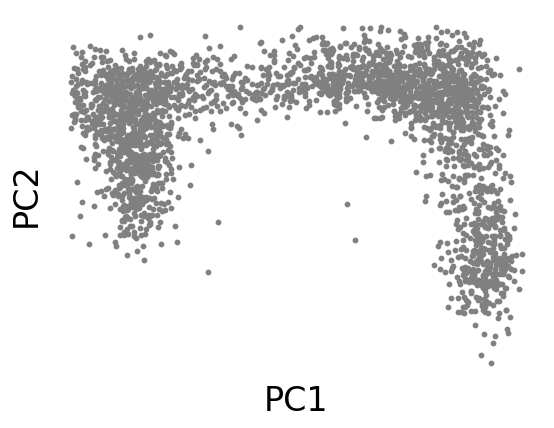

In [100]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [ ]:
from multiprocessing import Pool

tau = (0,8,16,24)
topo = np.array([[0,1,2,0]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,params={"r":rd,"Ub":Ub},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
with open('notebooks/results/scEU_seq_rpe1.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [101]:
with open('notebooks/results/scEU_seq_rpe1.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    trajs = pickle.load(f)

/tmp/ipykernel_3270607/2241376536.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(corrs,elbos,cmap='tab20')


Text(0.5, 1.0, 'Random initialiazation')

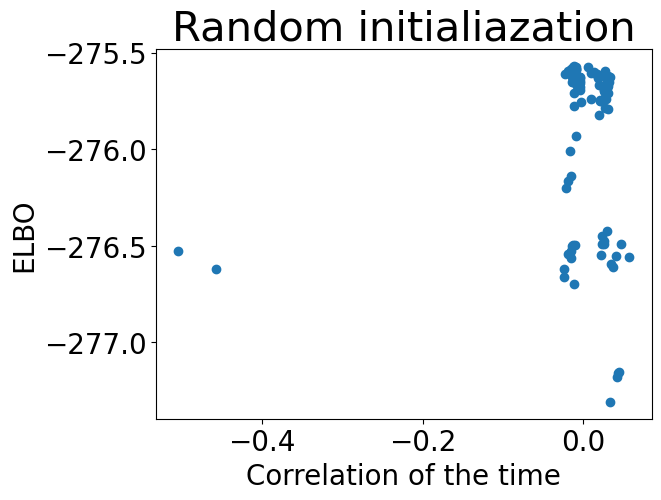

In [102]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    aligned_t_hat = np.roll(t_hat, -np.argmax(np.correlate(t_hat, right_t, mode='full')))
    corrs.append(spearmanr(right_t,aligned_t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

[ 0.          9.69489959 15.02823535 24.        ]


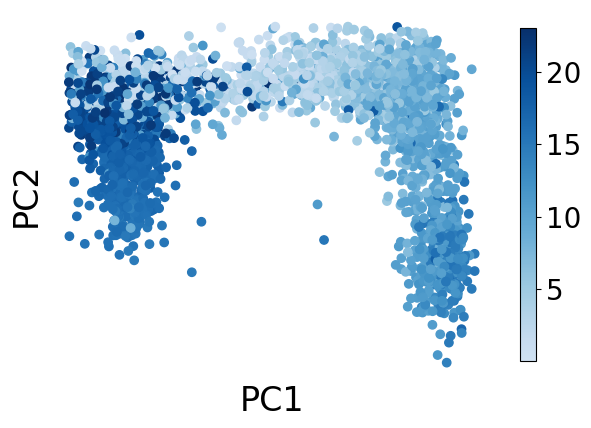

In [103]:
for ii in np.where(np.array(elbos)>-275.57)[0]:
    traj = trajs[ii]
    print(traj.tau)
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [119]:
traj = trajs[np.argmax(elbos)]
X = traj.X
print(np.max(elbos),traj.compute_AIC(traj.X,standard=False),traj.compute_BIC(traj.X,standard=False))

-275.5692328145162 -275.9070382769024 -276.5706800851914


0.16888135337061136
0.15035345266407496 1.3777407813764264


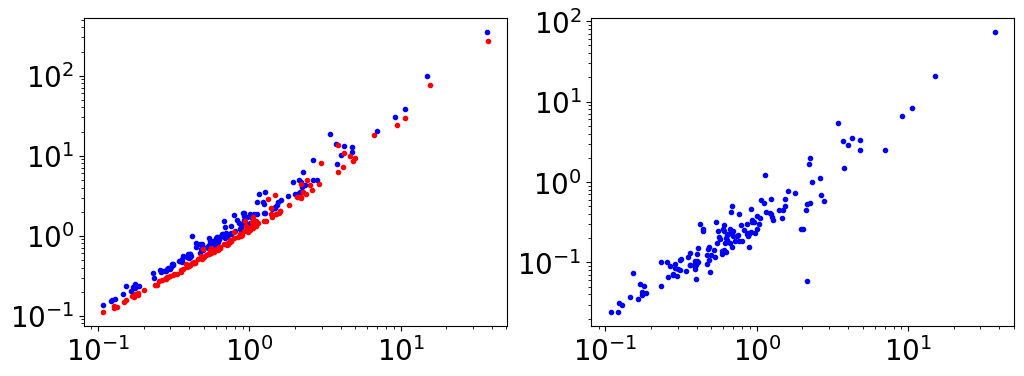

In [105]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(mean,var,'b.');
ax[0].loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.');
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())
ax[1].loglog(mean,unexplained,'b.');

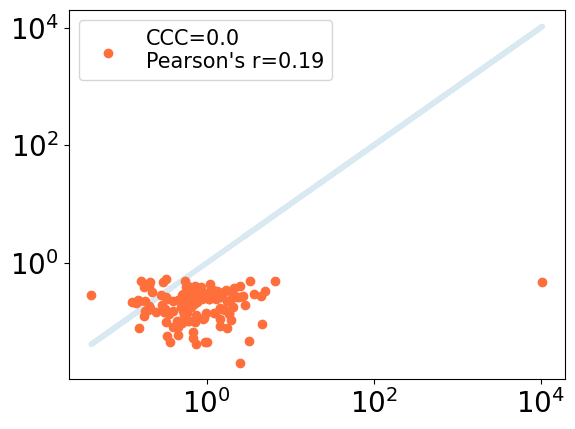

In [106]:
A = traj.theta[:,-1]
B = Battich_gamma[fitted_idx]
plot_cor(A,B)

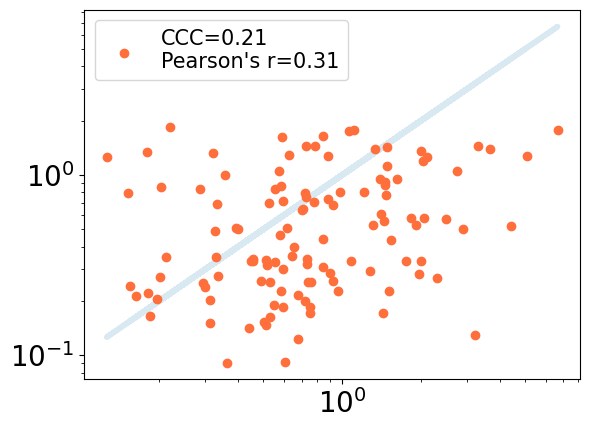

In [107]:
A = traj.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

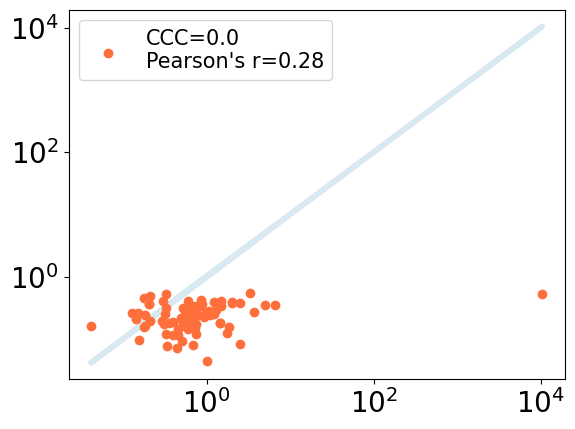

In [108]:
A = traj.theta[:,-1]
B = Dynamo_gamma[fitted_idx]
plot_cor(A,B)

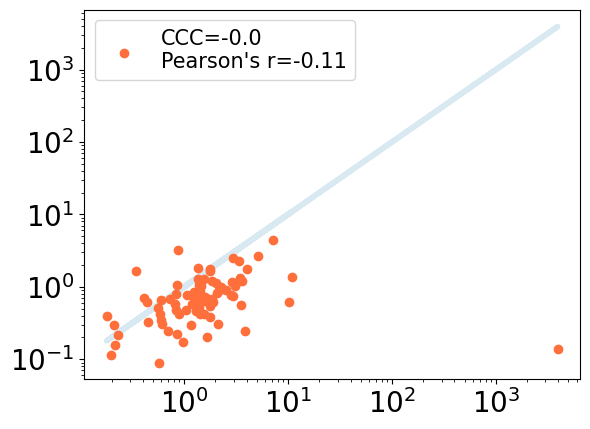

In [109]:
A = traj.theta[:,-2]
B = adata.var['beta'].astype(float)[fitted_idx]
plot_cor(A,B)

In [120]:
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params={"r":rd,"Ub":Ub,"lambda_tau":0},Q=traj.Q.copy(),parallel=True,n_threads=10,epoch=100)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 100/100 [19:18<00:00, 11.58s/it]

-362.3663423514543


[ 0.          9.69489959 15.02823535 24.        ]


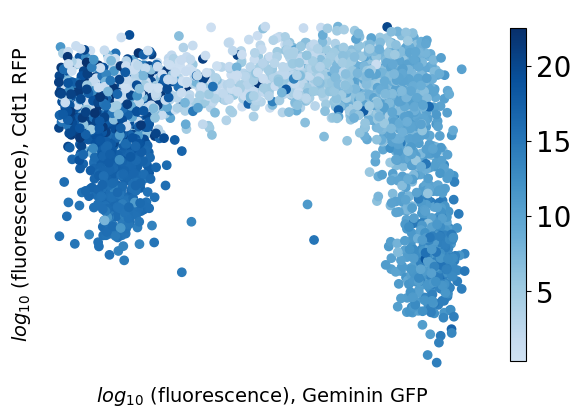

In [121]:
traj = traj_tau
print(traj.tau)
t_hat = np.sum(traj.Q@traj.t,axis=1)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel(r'$log_{10}$ (fluorescence), Geminin GFP',fontsize=14)
ax.set_ylabel(r'$log_{10}$ (fluorescence), Cdt1 RFP',fontsize=14)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

0.16888135337061136
0.1281913286306133 1.4036456749102262


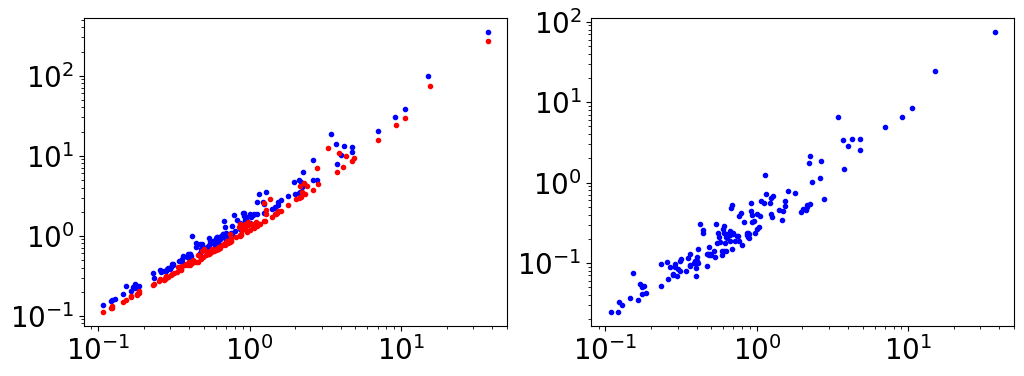

In [122]:
Y = traj_tau.get_Y_hat(traj_tau.theta, t_hat, traj_tau.tau, traj_tau.topo, traj_tau.params)[0]
rd_s = traj_tau.params['r'].var()/traj_tau.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(mean,var,'b.');
ax[0].loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.');
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())
ax[1].loglog(mean,unexplained,'b.');

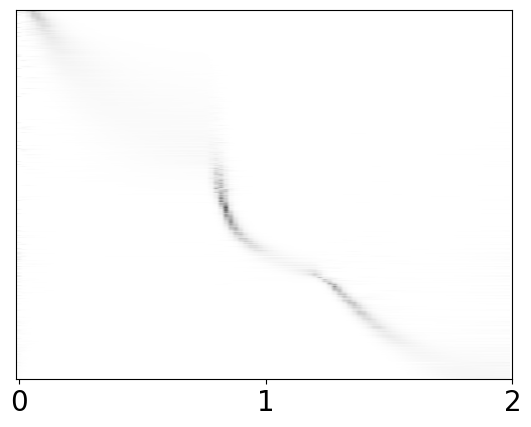

In [123]:
ax = plot_t(traj_tau,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

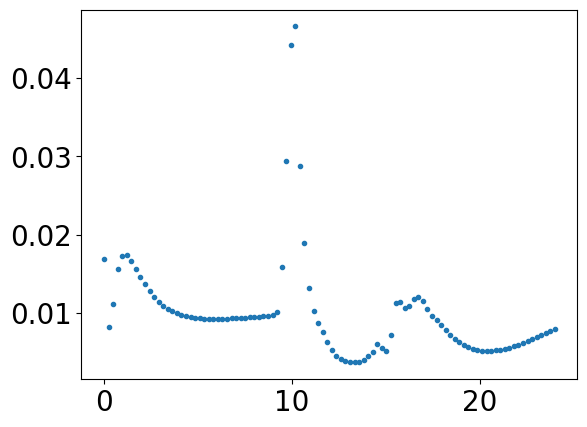

In [124]:
plt.plot(traj_tau.t,traj_tau.Q.sum((0,1))/traj_tau.Q.sum(),'.')

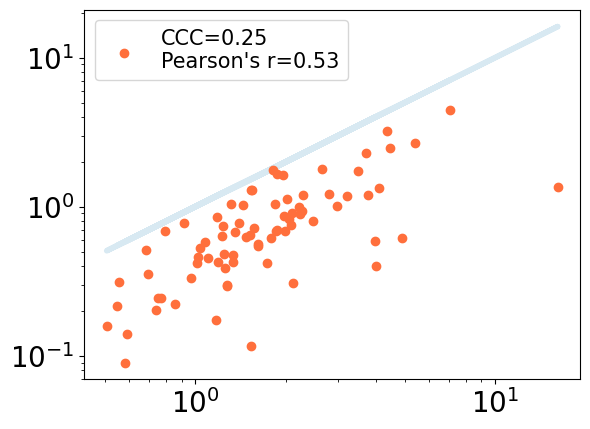

In [125]:
A = traj_tau.theta[:,-2]
B = adata.var['beta'].astype(float)[fitted_idx]
plot_cor(A,B)

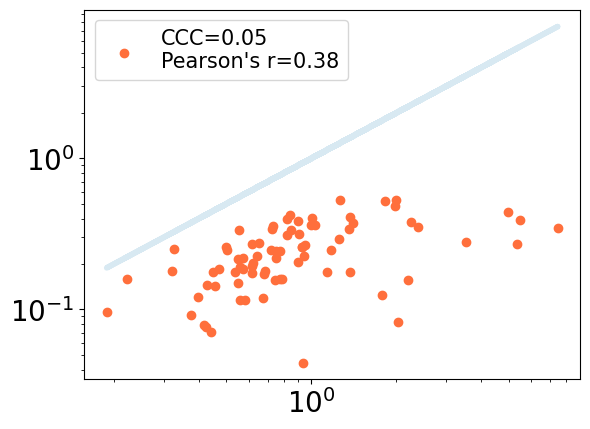

In [126]:
A = traj_tau.theta[:,-1]
B = adata.var['gamma'].astype(float)[fitted_idx]
plot_cor(A,B)

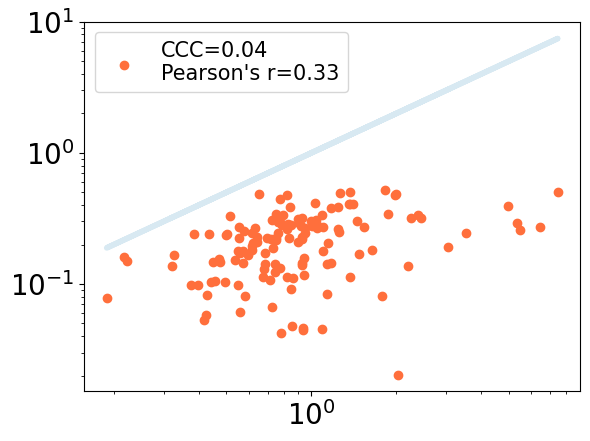

In [127]:
A = traj_tau.theta[:,-1]
B = Battich_gamma[fitted_idx]
plot_cor(A,B)

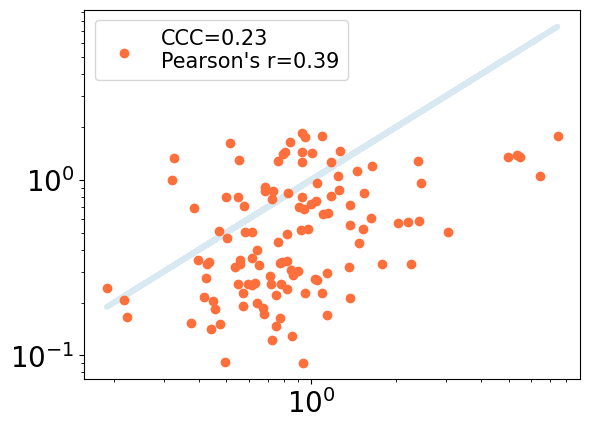

In [128]:
A = traj_tau.theta[:,-1]
B = Schofield_gamma[fitted_idx]
plot_cor(A,B)

In [ ]:
plot_phase(traj_tau,idx=plot_idx,gene_name=fitted_genes);

In [ ]:
plot_y(traj_tau,idx=plot_idx,gene_name=fitted_genes);

In [ ]:
Y = traj_tau.get_Y_hat(traj_tau.theta, traj_tau.t, traj_tau.tau, traj_tau.topo, traj.params)
fig, ax = plt.subplots(2,1,figsize=(6,8),tight_layout=True)
ax[0].loglog(Y[0,0,:,0],Y[0,0,:,0],'#d8e9f2',zorder=0,linewidth=4)
ax[0].scatter(Y[0,0,:,0],Y[0,-1,:,0],color='#113652')
ax[0].set_xlabel('Starting unspliced value',fontsize=16)
ax[0].set_ylabel('Ending unspliced value',fontsize=16)

ax[1].loglog(Y[0,0,:,1],Y[0,0,:,1],'#d8e9f2',zorder=0,linewidth=4)
ax[1].scatter(Y[0,0,:,1],Y[0,-1,:,1],color='#113652')
ax[1].set_xlabel('Starting spliced value',fontsize=16)
ax[1].set_ylabel('Ending spliced value',fontsize=16)

### two_species_ss_tau

In [ ]:
tau = (0,1,2,3)
topo = np.array([[0,1,2,0]])
Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss_tau", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plt.hist(traj.theta[:,-3])

In [ ]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [ ]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [ ]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [ ]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

In [ ]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

## Synthetic data

In [ ]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=10)

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()

Input_args = []
def fit_wrapper(seed):
    syn_traj = Trajectory(syn_topo, syn_tau, model="two_species_ss", verbose=0)
    syn_traj = syn_traj.fit(syn_X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return syn_traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    syn_trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for syn_traj in syn_trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)